In [1]:
%matplotlib inline

from pathlib import Path

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import backend as K

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

sns.set_style('whitegrid')
np.random.seed(42)
results_path = Path('results', 'cifar10')
if not results_path.exists():
    results_path.mkdir()

Using GPU


In [3]:
# load the pre-shuffled train and test data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [4]:
X_train.shape, y_train.shape

((50000, 32, 32, 3), (50000, 1))

In [8]:
X_train[:1]

array([[[[ 59,  62,  63],
         [ 43,  46,  45],
         [ 50,  48,  43],
         ...,
         [158, 132, 108],
         [152, 125, 102],
         [148, 124, 103]],

        [[ 16,  20,  20],
         [  0,   0,   0],
         [ 18,   8,   0],
         ...,
         [123,  88,  55],
         [119,  83,  50],
         [122,  87,  57]],

        [[ 25,  24,  21],
         [ 16,   7,   0],
         [ 49,  27,   8],
         ...,
         [118,  84,  50],
         [120,  84,  50],
         [109,  73,  42]],

        ...,

        [[208, 170,  96],
         [201, 153,  34],
         [198, 161,  26],
         ...,
         [160, 133,  70],
         [ 56,  31,   7],
         [ 53,  34,  20]],

        [[180, 139,  96],
         [173, 123,  42],
         [186, 144,  30],
         ...,
         [184, 148,  94],
         [ 97,  62,  34],
         [ 83,  53,  34]],

        [[177, 144, 116],
         [168, 129,  94],
         [179, 142,  87],
         ...,
         [216, 184, 140],
        

In [9]:
cifar10_labels = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
}
num_classes = len(cifar10_labels)
height, width, channels = X_train.shape[1:]
input_shape = height, width, channels
input_shape

(32, 32, 3)

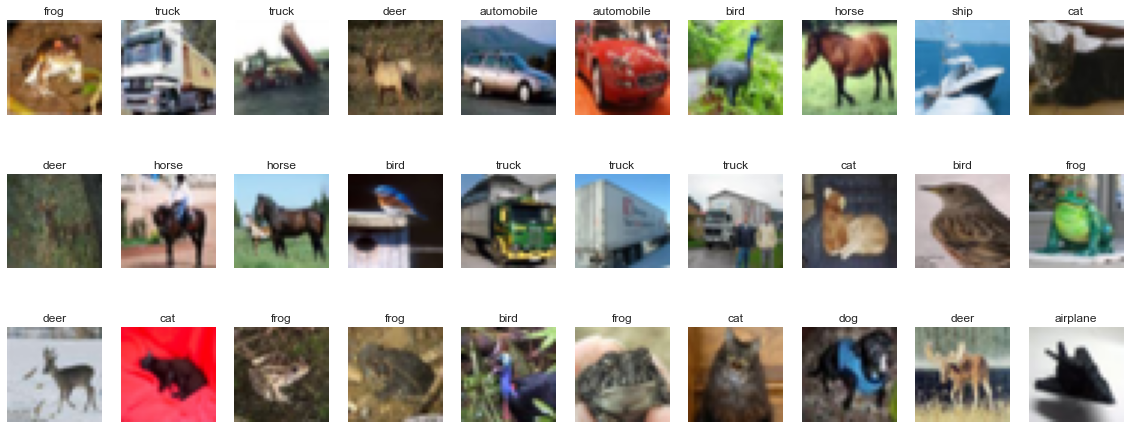

In [11]:
fig, axes = plt.subplots(nrows=3, ncols=10, figsize=(20, 8))
axes = axes.flatten()
for i, ax in enumerate(axes):
    ax.imshow(np.squeeze(X_train[i]))
    ax.axis('off')
    ax.set_title(cifar10_labels[y_train[i, 0]])

In [12]:
# Rescale the Images
X_train = X_train.astype('float32') / 255 # rescale [0,255] --> [0,1]
X_test = X_test.astype('float32') / 255

# Train-Test split
X_train, X_valid = X_train[5000:], X_train[:5000]
y_train, y_valid = y_train[5000:], y_train[:5000]

X_train.shape # shape of training set

(45000, 32, 32, 3)

In [13]:
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')
print(X_valid.shape[0], 'validation samples')

45000 train samples
10000 test samples
5000 validation samples


In [14]:
# Feedforward Neural Network
mlp = Sequential([
    Flatten(input_shape=input_shape, name='input'),
    Dense(1000, activation='relu', name='hidden_layer_1'),
    Dropout(0.2, name='droput_1'),
    Dense(512, activation='relu', name='hidden_layer_2'),
    Dropout(0.2, name='dropout_2'),
    Dense(num_classes, activation='softmax', name='output')
])
mlp.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (Flatten)             (None, 3072)              0         
                                                                 
 hidden_layer_1 (Dense)      (None, 1000)              3073000   
                                                                 
 droput_1 (Dropout)          (None, 1000)              0         
                                                                 
 hidden_layer_2 (Dense)      (None, 512)               512512    
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 output (Dense)              (None, 10)                5130      
                                                                 
Total params: 3,590,642
Trainable params: 3,590,642
Non-

In [15]:
mlp.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define Callbacks
mlp_path = (results_path / 'mlp.weights.best.hdf5').as_posix()
checkpointer = ModelCheckpoint(filepath=mlp_path, verbose=1, monitor='val_accuracy', save_best_only=True)
tensorboard = TensorBoard(log_dir=results_path / 'logs' / 'mlp', histogram_freq=1, write_graph=True,
                          write_grads=False, update_freq='epoch')
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10)

In [16]:
# Train the Model
batch_size = 32
epochs = 100
mlp_history = mlp.fit(X_train, y_train, batch_size=batch_size, epochs=epochs,
                      validation_data=(X_valid, y_valid), workers=6,
                      callbacks=[checkpointer, tensorboard, early_stopping], verbose=1, shuffle=True)

Epoch 1/100
1402/1407 [============================>.] - ETA: 0s - loss: 1.9840 - accuracy: 0.2734
Epoch 00001: val_accuracy improved from -inf to 0.35960, saving model to results/cifar10\mlp.weights.best.hdf5
1407/1407 [==============================] - 11s 5ms/step - loss: 1.9837 - accuracy: 0.2734 - val_loss: 1.7982 - val_accuracy: 0.3596
Epoch 2/100
1406/1407 [============================>.] - ETA: 0s - loss: 1.8489 - accuracy: 0.3216
Epoch 00002: val_accuracy did not improve from 0.35960
1407/1407 [==============================] - 5s 3ms/step - loss: 1.8488 - accuracy: 0.3216 - val_loss: 1.7558 - val_accuracy: 0.3570
Epoch 3/100
1401/1407 [============================>.] - ETA: 0s - loss: 1.7861 - accuracy: 0.3460
Epoch 00003: val_accuracy improved from 0.35960 to 0.39980, saving model to results/cifar10\mlp.weights.best.hdf5
1407/1407 [==============================] - 4s 3ms/step - loss: 1.7859 - accuracy: 0.3461 - val_loss: 1.6986 - val_accuracy: 0.3998
Epoch 4/100
1393/1407 [

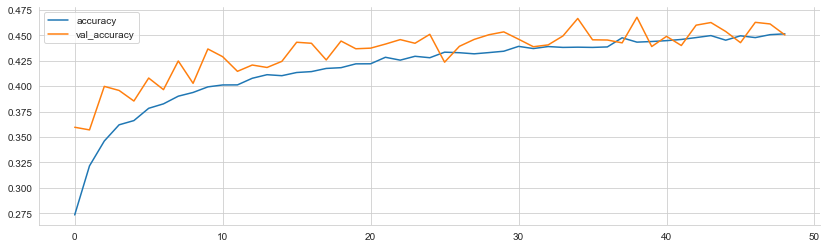

In [17]:
# Plot CV Results
pd.DataFrame(mlp_history.history)[['accuracy', 'val_accuracy']].plot(figsize=(14, 4))
sns.despine()

In [18]:
# Load best model
mlp.load_weights(mlp_path) # load the weights that yielded the best validation accuracy

# Test Classification Accuracy
mlp_accuracy = mlp.evaluate(X_test, y_test, verbose=0)[1]
print(f'Feedforward Neural Network Test accuracy: {mlp_accuracy:.2%}')

Feedforward Neural Network Test accuracy: 46.72%


In [19]:
# Convolutional Neural Network
# https://stackoverflow.com/questions/35114376/error-when-computing-summaries-in-tensorflow/35117760#35117760
K.clear_session()

# Model Architecture
cnn = Sequential([Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', input_shape=input_shape,
           name='CONV1'),
    MaxPooling2D(pool_size=2, name='POOL1'),
    Conv2D(filters=32, kernel_size=2, padding='same', activation='relu', name='CONV2'),
    MaxPooling2D(pool_size=2, name='POOL2'),
    Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', name='CONV3'),
    MaxPooling2D(pool_size=2, name='POOL3'),
    Dropout(0.3, name='DROP1'),
    Flatten(name='FLAT1'),
    Dense(500, activation='relu', name='FC1'),
    Dropout(0.4, name='DROP2'),
    Dense(10, activation='softmax', name='FC2')
])

cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 CONV1 (Conv2D)              (None, 32, 32, 16)        208       
                                                                 
 POOL1 (MaxPooling2D)        (None, 16, 16, 16)        0         
                                                                 
 CONV2 (Conv2D)              (None, 16, 16, 32)        2080      
                                                                 
 POOL2 (MaxPooling2D)        (None, 8, 8, 32)          0         
                                                                 
 CONV3 (Conv2D)              (None, 8, 8, 64)          8256      
                                                                 
 POOL3 (MaxPooling2D)        (None, 4, 4, 64)          0         
                                                                 
 DROP1 (Dropout)             (None, 4, 4, 64)          0

In [20]:
# Compile the Model
cnn.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define Callbacks
cnn_path = (results_path / 'cnn.weights.best.hdf5').as_posix()
checkpointer = ModelCheckpoint(filepath=cnn_path, verbose=1, monitor='val_accuracy', save_best_only=True)
tensorboard = TensorBoard(log_dir=results_path / 'logs' / 'cnn', histogram_freq=1, write_graph=True,
                          write_grads=False, update_freq='epoch')
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10)

In [21]:
# Train the Model
batch_size = 32
epochs = 100
cnn_history = cnn.fit(X_train, y_train, batch_size=batch_size, epochs=epochs,
                      validation_data=(X_valid, y_valid),
                      callbacks=[checkpointer, tensorboard, early_stopping],
                      verbose=2, shuffle=True, workers=6)

Epoch 1/100

Epoch 00001: val_accuracy improved from -inf to 0.53800, saving model to results/cifar10\cnn.weights.best.hdf5
1407/1407 - 16s - loss: 1.5916 - accuracy: 0.4173 - val_loss: 1.3023 - val_accuracy: 0.5380 - 16s/epoch - 11ms/step
Epoch 2/100

Epoch 00002: val_accuracy improved from 0.53800 to 0.59620, saving model to results/cifar10\cnn.weights.best.hdf5
1407/1407 - 5s - loss: 1.2857 - accuracy: 0.5385 - val_loss: 1.1345 - val_accuracy: 0.5962 - 5s/epoch - 4ms/step
Epoch 3/100

Epoch 00003: val_accuracy improved from 0.59620 to 0.62320, saving model to results/cifar10\cnn.weights.best.hdf5
1407/1407 - 5s - loss: 1.1574 - accuracy: 0.5868 - val_loss: 1.0388 - val_accuracy: 0.6232 - 5s/epoch - 4ms/step
Epoch 4/100

Epoch 00004: val_accuracy improved from 0.62320 to 0.67520, saving model to results/cifar10\cnn.weights.best.hdf5
1407/1407 - 6s - loss: 1.0761 - accuracy: 0.6170 - val_loss: 0.9432 - val_accuracy: 0.6752 - 6s/epoch - 4ms/step
Epoch 5/100

Epoch 00005: val_accuracy d

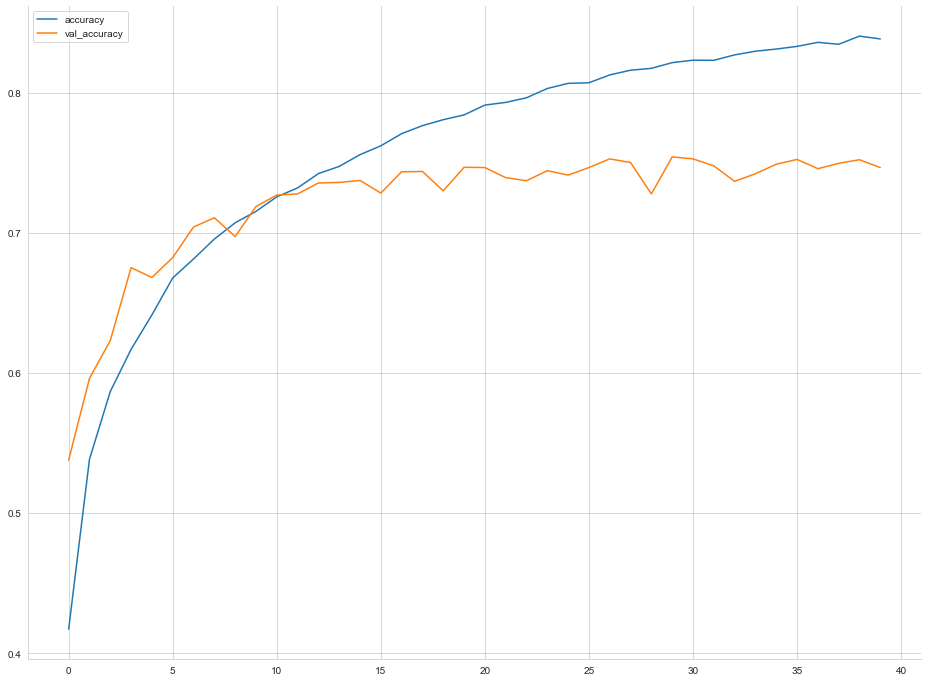

In [22]:
# Plot CV Results
pd.DataFrame(cnn_history.history)[['accuracy', 'val_accuracy']].plot(figsize=(16, 12))
sns.despine();

In [23]:
# Load best model
cnn.load_weights(cnn_path)

# Test set accuracy
cnn_accuracy = cnn.evaluate(X_test, y_test, verbose=0)[1]
print('CNN Accuracy: {:.2%}'.format(cnn_accuracy))

CNN Accuracy: 73.91%


D:\99.Dev\Python\pythonProject\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from current font.
  func(*args, **kwargs)
D:\99.Dev\Python\pythonProject\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


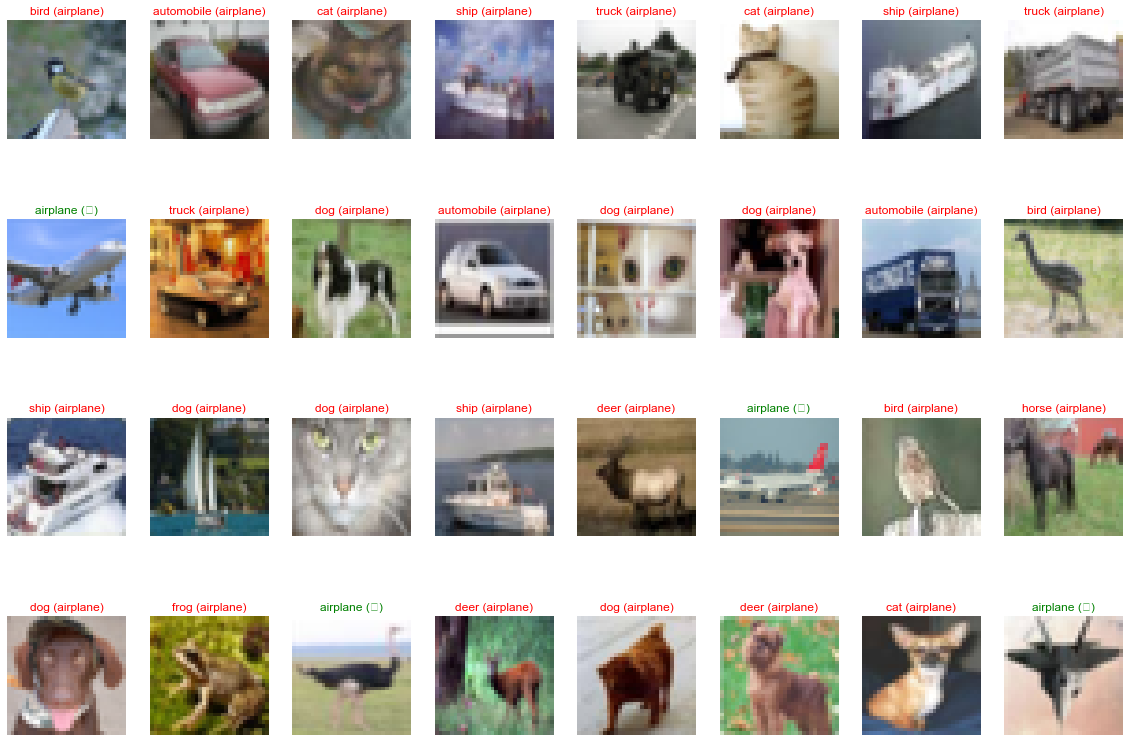

In [24]:
# Evaluate Predictions
y_hat = cnn.predict(X_test)
fig, axes = plt.subplots(nrows=4, ncols=8, figsize=(20, 14))
axes = axes.flatten()
images = np.random.choice(X_test.shape[0], size=32, replace=False)
for i, (ax, idx) in enumerate(zip(axes, images)):
    ax.imshow(np.squeeze(X_test[idx]))
    ax.axis('off')
    pred_idx, true_idx = np.argmax(y_hat[idx]), np.argmax(y_test[idx])
    if pred_idx == true_idx:
        ax.set_title('{} (✓)'.format(cifar10_labels[pred_idx]), color="green")
    else:
        ax.set_title("{} ({})".format(cifar10_labels[pred_idx], cifar10_labels[true_idx]), color='red')

In [25]:
# Create and configure augmented image generator
datagen = ImageDataGenerator(
    width_shift_range=0.1,  # randomly horizontal shift
    height_shift_range=0.1,  # randomly vertial shift
    horizontal_flip=True)  # randomly horizontalflip

# fit augmented image generator on data
datagen.fit(X_train)

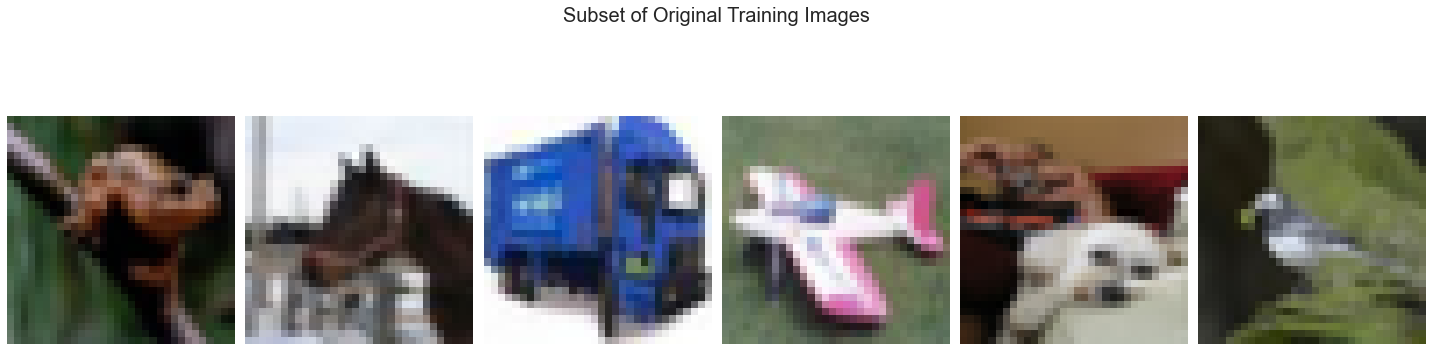

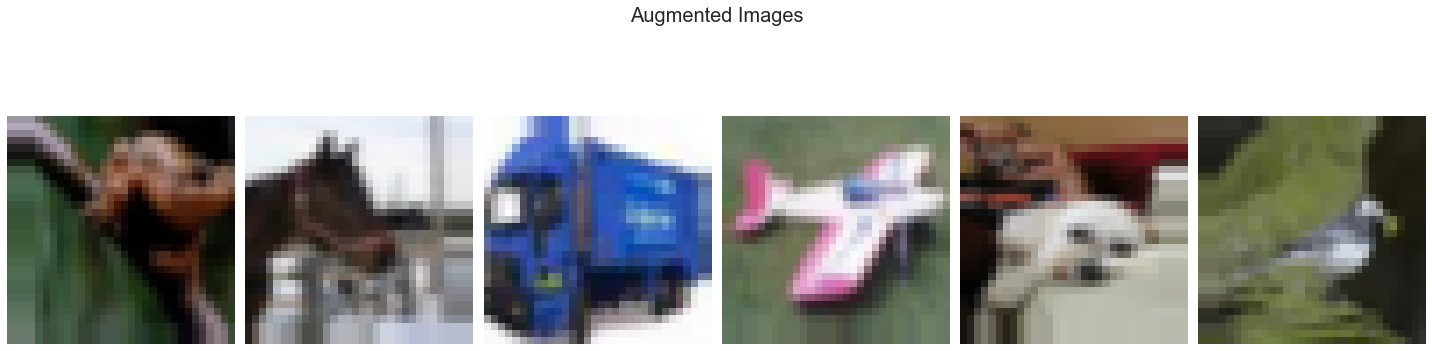

In [26]:
# Visualize subset of training data
n_images = 6
x_train_subset = X_train[:n_images]

# original images
fig, axes = plt.subplots(nrows=1, ncols=n_images, figsize=(20, 6))
for i, (ax, img) in enumerate(zip(axes, x_train_subset)):
    ax.imshow(img)
    ax.axis('off')
fig.suptitle('Subset of Original Training Images', fontsize=20)
fig.tight_layout()
fig.subplots_adjust(top=.9)
fig.savefig(results_path / 'original_images')

# augmented images
fig, axes = plt.subplots(nrows=1, ncols=n_images, figsize=(20, 6))
for x_batch in datagen.flow(x_train_subset, batch_size=n_images, shuffle=False):
    for i, ax in enumerate(axes):
        ax.imshow(x_batch[i])
        ax.axis('off')
#     fig.suptitle('Augmented Images', fontsize=20)
    break
fig.suptitle('Augmented Images', fontsize=20)
fig.tight_layout()
fig.subplots_adjust(top=.9)
fig.savefig(results_path / 'augmented_images')

In [27]:
# Define Callbacks
K.clear_session()

cnn_aug_path = (results_path / 'augmented.cnn.weights.best.hdf5').as_posix()
checkpointer = ModelCheckpoint(filepath=cnn_aug_path, verbose=1, monitor='val_accuracy', save_best_only=True)
tensorboard = TensorBoard(log_dir=results_path / 'logs' / 'cnn_aug', histogram_freq=1, write_graph=True,
                          write_grads=False, update_freq='epoch')
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10)

In [28]:
# Train Augmented Images
batch_size = 32
epochs = 100
cnn_aug_history = cnn.fit(datagen.flow(X_train, y_train, batch_size=batch_size),
                          steps_per_epoch=X_train.shape[0] // batch_size,
                          epochs=epochs, validation_data=(X_valid, y_valid),
                          callbacks=[checkpointer, tensorboard, early_stopping],
                          verbose=2, workers=6)

Epoch 1/100

Epoch 00001: val_accuracy improved from -inf to 0.71280, saving model to results/cifar10\augmented.cnn.weights.best.hdf5
1406/1406 - 13s - loss: 1.0023 - accuracy: 0.6519 - val_loss: 0.8523 - val_accuracy: 0.7128 - 13s/epoch - 9ms/step
Epoch 2/100

Epoch 00002: val_accuracy improved from 0.71280 to 0.73720, saving model to results/cifar10\augmented.cnn.weights.best.hdf5
1406/1406 - 13s - loss: 0.9568 - accuracy: 0.6691 - val_loss: 0.8031 - val_accuracy: 0.7372 - 13s/epoch - 9ms/step
Epoch 3/100

Epoch 00003: val_accuracy did not improve from 0.73720
1406/1406 - 13s - loss: 0.9368 - accuracy: 0.6735 - val_loss: 0.8007 - val_accuracy: 0.7288 - 13s/epoch - 9ms/step
Epoch 4/100

Epoch 00004: val_accuracy improved from 0.73720 to 0.74020, saving model to results/cifar10\augmented.cnn.weights.best.hdf5
1406/1406 - 12s - loss: 0.9216 - accuracy: 0.6763 - val_loss: 0.7721 - val_accuracy: 0.7402 - 12s/epoch - 9ms/step
Epoch 5/100

Epoch 00005: val_accuracy improved from 0.74020 to 

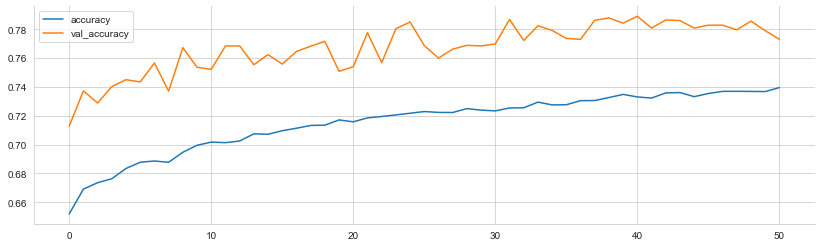

In [29]:
# Plot CV Result
pd.DataFrame(cnn_aug_history.history)[['accuracy', 'val_accuracy']].plot(figsize=(14, 4))
sns.despine();

In [30]:
# Load best model
cnn.load_weights(cnn_aug_path)

cnn_aug_accuracy = cnn.evaluate(X_test, y_test, verbose=0)[1]
print('CNN Augmented Test Accuracy: {:.2%}'.format(cnn_aug_accuracy))

CNN Augmented Test Accuracy: 77.62%


In [39]:
# AlexNet
K.clear_session()

alexnet = Sequential([
    # 1st Convolutional Layer
    Conv2D(96, (3, 3), strides=(2, 2), activation='relu', padding='same',
           input_shape=input_shape, name='CONV_1'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='POOL_1'),
    BatchNormalization(name='NORM_1'),

    # 2nd Convolutional Layer
    Conv2D(filters=256, kernel_size=(5, 5), padding='same', activation='relu', name='CONV2'),
    MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='POOL2'),
    BatchNormalization(name='NORM_2'),

    # 3rd Convolutional Layer
    Conv2D(filters=384, kernel_size=(3, 3), padding='same', activation='relu', name='CONV3'),

    # 4th Convolutional Layer
    Conv2D(filters=384, kernel_size=(3, 3), padding='same', activation='relu', name='CONV4'),

    # 5th Convolutional Layer
    Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu', name='CONV5'),
    MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='POOL5'),
    BatchNormalization(name='NORM_5'),

    # Fully Connected Layers
    Flatten(name='FLAT'),
    Dense(4096, input_shape=(32 * 32 * 3, ), activation='relu', name='FC1'),
    Dropout(0.4, name='DROP1'),
    Dense(4096, activation='relu', name='FC2'),
    Dropout(0.4, name='DROP2'),
    Dense(num_classes, activation='softmax')
])
alexnet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 CONV_1 (Conv2D)             (None, 16, 16, 96)        2688      
                                                                 
 POOL_1 (MaxPooling2D)       (None, 8, 8, 96)          0         
                                                                 
 NORM_1 (BatchNormalization)  (None, 8, 8, 96)         384       
                                                                 
 CONV2 (Conv2D)              (None, 8, 8, 256)         614656    
                                                                 
 POOL2 (MaxPooling2D)        (None, 3, 3, 256)         0         
                                                                 
 NORM_2 (BatchNormalization)  (None, 3, 3, 256)        1024      
                                                                 
 CONV3 (Conv2D)              (None, 3, 3, 384)         8

In [40]:
# Compile Model
alexnet.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define Callbacks
alexnet_path = (results_path / 'alexnet.weights.best.hdf5').as_posix()
checkpointer = ModelCheckpoint(filepath=alexnet_path, verbose=1, monitor='val_accuracy', save_best_only=True)
tensorboard = TensorBoard(log_dir=results_path / 'logs' / 'alexnet', histogram_freq=1, write_graph=True,
                          write_grads=False, update_freq='epoch')
early_stopping = EarlyStopping(monitor='val_accuracy', mode='max', patience=10)

In [41]:
# Train Model
batch_size = 32
epochs = 100
alex_history = alexnet.fit(X_train, y_train, batch_size=batch_size, epochs=epochs,
                           validation_data=(X_valid, y_valid),
                           callbacks=[checkpointer, tensorboard, early_stopping],
                           verbose=1, workers=6)

Epoch 1/100
1407/1407 [==============================] - ETA: 0s - loss: 1.6069 - accuracy: 0.4324
Epoch 00001: val_accuracy improved from -inf to 0.10180, saving model to results/cifar10\alexnet.weights.best.hdf5
1407/1407 [==============================] - 36s 24ms/step - loss: 1.6069 - accuracy: 0.4324 - val_loss: 6.4043 - val_accuracy: 0.1018
Epoch 2/100
1405/1407 [============================>.] - ETA: 0s - loss: 1.2725 - accuracy: 0.5623
Epoch 00002: val_accuracy improved from 0.10180 to 0.58200, saving model to results/cifar10\alexnet.weights.best.hdf5
1407/1407 [==============================] - 30s 20ms/step - loss: 1.2722 - accuracy: 0.5623 - val_loss: 1.2409 - val_accuracy: 0.5820
Epoch 3/100
1404/1407 [============================>.] - ETA: 0s - loss: 1.0273 - accuracy: 0.6535
Epoch 00003: val_accuracy improved from 0.58200 to 0.62300, saving model to results/cifar10\alexnet.weights.best.hdf5
1407/1407 [==============================] - 25s 18ms/step - loss: 1.0270 - accura

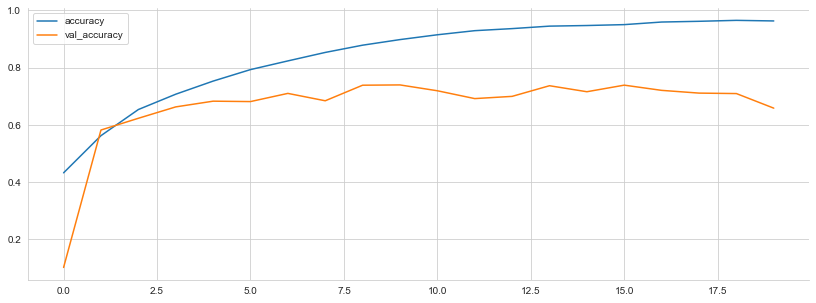

In [42]:
pd.DataFrame(alex_history.history)[['accuracy', 'val_accuracy']].plot(figsize=(14, 5))
sns.despine()

In [43]:
alexnet.load_weights(alexnet_path)

In [44]:
alex_accuracy = alexnet.evaluate(X_test, y_test, verbose=0)[1]
print('Alexnet Test Accuracy: {:.2%}'.format(alex_accuracy))

Alexnet Test Accuracy: 73.15%


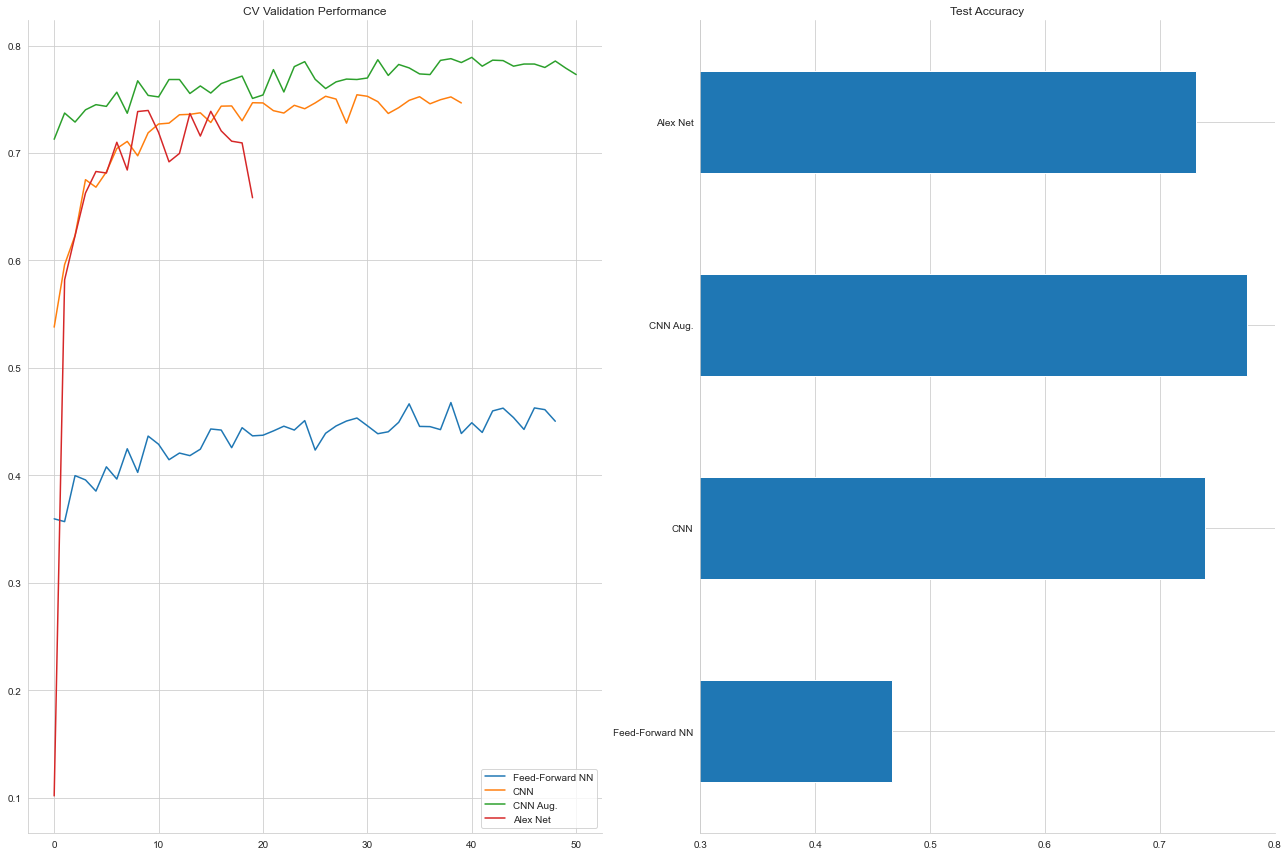

In [45]:
# Compare Results
cv_results = pd.DataFrame(
    {'Feed-Forward NN': pd.Series(mlp_history.history['val_accuracy']),
    'CNN': pd.Series(cnn_history.history['val_accuracy']),
    'CNN Aug.': pd.Series(cnn_aug_history.history['val_accuracy']),
    'Alex Net': pd.Series(alex_history.history['val_accuracy'])})

test_accuracy = pd.Series({
    'Feed-Forward NN': mlp_accuracy,
    'CNN': cnn_accuracy,
    'CNN Aug.': cnn_aug_accuracy,
    'Alex Net': alex_accuracy})

fig, axes = plt.subplots(ncols=2, figsize=(18, 12))
cv_results.plot(ax=axes[0], title='CV Validation Performance')
test_accuracy.plot.barh(ax=axes[1], xlim=(.3, .8), title='Test Accuracy')
fig.tight_layout()
sns.despine()
fig.savefig(results_path / 'comparison', dpi=300);

In [38]:
# TensorBoard visualization
%load_ext tensorboard
%tensorboard --logdir results/cifar10/logs

Launching TensorBoard...